In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import keras
import pandas as pd
import math
import joblib

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from IPython.display import display
from fuel.datasets.hdf5 import H5PYDataset

Using TensorFlow backend.


In [2]:
ftrain = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('train',))
X_train, y_train = ftrain.get_data(ftrain.open(), slice(0, ftrain.num_examples))
X_train = np.moveaxis(X_train[:], 1, 3)
X_train = X_train / 255.

ftest = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('test',))
X_test, y_test = ftest.get_data(ftest.open(), slice(0, ftest.num_examples))
X_test = np.moveaxis(X_test[:], 1, 3)
X_test = X_test / 255.
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


# Load Models

In [3]:
encoder_path = "saved_models/vae-m1-encoder.hdf5"
encoder = keras.models.load_model(encoder_path)

generator_path = "saved_models/vae-m1-generator.hdf5"
generator = keras.models.load_model(generator_path)

/home/brian/anaconda3/lib/python3.6/site-packages/keras/models.py:258: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Sample Some Random Images

In [4]:
digit_size = 32
img_rows, img_cols, img_chns = 32, 32, 3
latent_dim = 512

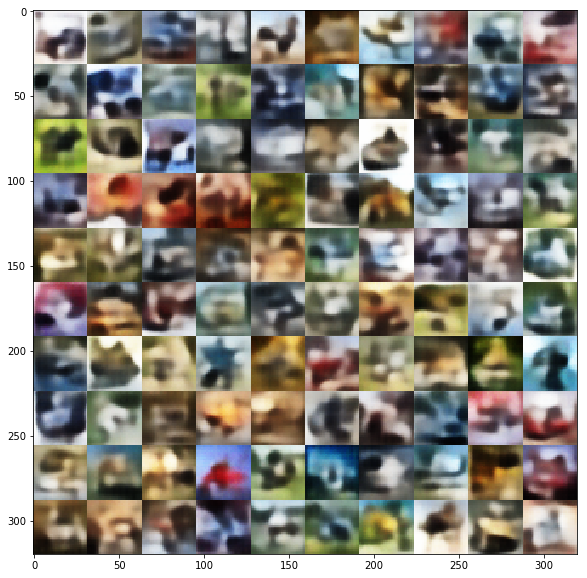

In [5]:
n = 10
figure = np.zeros((digit_size * n, digit_size * n, img_chns))

for i in range(n):
    for j in range(n):
        z_sample = np.random.normal(size=latent_dim).reshape(1, latent_dim)
        x_decoded = generator.predict(z_sample, batch_size=1)
        digit = x_decoded.reshape(digit_size, digit_size, img_chns)
        
        d_x = i * digit_size
        d_y = j * digit_size
        figure[d_x:d_x + digit_size, d_y:d_y + digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# Load features

In [6]:
batch_size = 250
X_test_decoded = encoder.predict(X_test, batch_size=batch_size)

results = []
for sample_size in [1000, 2000, 5000, 10000, 25000, 50000]:
    start = time.time()
    print('Fitting with sample_size: {}'.format(sample_size))
    model = SVC()
   
    if sample_size < len(X_train):
        sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size / len(X_train), random_state=0)
        _, index = sss.split(X_train, y_train)
        X, y = X_train[index[1]], y_train[index[1]]
    else:
        X, y = X_train, y_train
    
    X_latent = encoder.predict(X, batch_size=batch_size)
    model.fit(X_latent, y.ravel())
    
    X_test_latent = encoder.predict(X_test, batch_size=batch_size)
    y_pred = model.predict(X_test_latent)
    score = accuracy_score(y_test, y_pred)
    
    end = time.time()
    elapsed = end - start
    print(' * Accuracy: %.1f %%' % (100. * score))
    print(' * Fit time elapsed: %.1fs' % elapsed)
    results.append({'sample_size': sample_size, 'accuracy': score, 'time': elapsed})

Fitting with sample_size: 1000
 * Accuracy: 32.1 %
 * Fit time elapsed: 7.3s
Fitting with sample_size: 2000
 * Accuracy: 36.2 %
 * Fit time elapsed: 15.6s
Fitting with sample_size: 5000
 * Accuracy: 37.5 %
 * Fit time elapsed: 46.8s
Fitting with sample_size: 10000
 * Accuracy: 38.9 %
 * Fit time elapsed: 127.8s
Fitting with sample_size: 25000
 * Accuracy: 40.9 %
 * Fit time elapsed: 529.9s
Fitting with sample_size: 50000
 * Accuracy: 41.9 %
 * Fit time elapsed: 1745.5s


In [7]:
df = pd.DataFrame(results)
display(df)
df.to_csv('vae_m1_results.csv', index=False)

,accuracy,sample_size,time
0,0.3214,1000,7.312939
1,0.3618,2000,15.627824
2,0.3755,5000,46.830929
3,0.3894,10000,127.809392
4,0.4089,25000,529.862856
5,0.4188,50000,1745.489242
